# Deep Q-Learning - Lunar Lander

In this assignment, you will train an agent to land a lunar lander safely on a landing pad on the surface of the moon.


# Outline
- [ 1 - Import Packages <img align="Right" src="./images/lunar_lander.gif" width = 60% >](#1)
- [ 2 - Hyperparameters](#2)
- [ 3 - The Lunar Lander Environment](#3)
  - [ 3.1 Action Space](#3.1)
  - [ 3.2 Observation Space](#3.2)
  - [ 3.3 Rewards](#3.3)
  - [ 3.4 Episode Termination](#3.4)
- [ 4 - Load the Environment](#4)
- [ 5 - Interacting with the Gym Environment](#5)
    - [ 5.1 Exploring the Environment's Dynamics](#5.1)
- [ 6 - Deep Q-Learning](#6)
  - [ 6.1 Target Network](#6.1)
    - [ Exercise 1](#ex01)
  - [ 6.2 Experience Replay](#6.2)
- [ 7 - Deep Q-Learning Algorithm with Experience Replay](#7)
  - [ Exercise 2](#ex02)
- [ 8 - Update the Network Weights](#8)
- [ 9 - Train the Agent](#9)
- [ 10 - See the Trained Agent In Action](#10)
- [ 11 - Congratulations!](#11)
- [ 12 - References](#12)


_**NOTE:** To prevent errors from the autograder, you are not allowed to edit or delete non-graded cells in this lab. Please also refrain from adding any new cells. 
**Once you have passed this assignment** and want to experiment with any of the non-graded code, you may follow the instructions at the bottom of this notebook._

<a name="1"></a>
## 1 - Import Packages

We'll make use of the following packages:
- `numpy` is a package for scientific computing in python.
- `deque` will be our data structure for our memory buffer.
- `namedtuple` will be used to store the experience tuples.
- The `gym` toolkit is a collection of environments that can be used to test reinforcement learning algorithms. We should note that in this notebook we are using `gym` version `0.24.0`.
- `PIL.Image` and `pyvirtualdisplay` are needed to render the Lunar Lander environment.
- We will use several modules from the `tensorflow.keras` framework for building deep learning models.
- `utils` is a module that contains helper functions for this assignment. You do not need to modify the code in this file.

Run the cell below to import all the necessary packages.

In [1]:
# pip install gym==0.24.0


In [2]:
import time
from collections import deque, namedtuple
'''
time → Provides functions to work with time, e.g., time.sleep() to pause execution.
collections.deque → A double-ended queue. Efficient for adding/removing elements from both ends. Often used for experience replay buffers in RL.
collections.namedtuple → Creates simple, immutable “tuple-like” objects with named fields. Useful for storing RL experiences like (state, action, reward, next_state) neatly.
'''

import gym
import numpy as np
import PIL.Image
'''
gym → OpenAI Gym library. Provides reinforcement learning environments like LunarLander-v2 or CartPole-v1.
numpy → The backbone of numerical computation in Python. Handles arrays, matrices, and vectorized operations efficiently.
PIL.Image → Part of the Pillow library (Python Imaging Library). Used to process images, e.g., if your RL environment returns frames as images.
'''
import tensorflow as tf
'''
tensorflow → Popular deep learning library. Here it will be used to build neural networks (like Q-networks in DQN) and train them using gradient descent.
'''
import utils

from pyvirtualdisplay import Display
'''
pyvirtualdisplay → Allows running graphics/rendering in environments without a physical display (headless mode).
'''
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
'''
Sequential → A simple way to define neural networks layer by layer.
Dense → Fully connected layer: every neuron connects to all neurons in the previous layer.
Input → Define the input shape of the network.
MSE → Mean Squared Error loss. Commonly used for regression problems and Q-learning targets.
Adam → Popular optimizer for training neural networks. Automatically adjusts learning rates and is robust.

1. What is Adam?
Adam stands for Adaptive Moment Estimation.
It’s an optimizer, which means its job is to update the weights of your neural network in a way that reduces your loss function.
Adam combines the best of two worlds:
Momentum → remembers past gradients to smooth updates
RMSProp → adapts learning rates for each weight individually
This makes Adam fast, stable, and efficient for a wide variety of problems.
'''
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="pygame.pkgdata")


Additionally, Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
# # Set up a virtual display to render the Lunar Lander environment.
# Display(visible=0, size=(840, 480)).start();

# # Set the random seed for TensorFlow
# tf.random.set_seed(utils.SEED)

In [4]:
# macOS: no need for a virtual display
# Display(visible=0, size=(840, 480)).start()  # REMOVE THIS

# # Set the random seed for TensorFlow
# tf.random.set_seed(utils.SEED)

# # Create the Lunar Lander environment
# env = gym.make("LunarLander-v2")
# env.reset()
# '''
# gym.make("LunarLander-v2") creates an instance of the Lunar Lander environment from OpenAI Gym.
# env.reset() initializes the environment, placing the lander at the starting position and returning the initial observation (state).
# '''
# # Example: render a few steps
# for _ in range(10):
#     env.render()  # This will open a window on macOS
#     env.step(env.action_space.sample())
# '''
# Loops 10 times to interact with the environment.
# env.render() opens a window showing the simulation (the lander moving on the screen).
# env.step(env.action_space.sample()) takes a random action in the environment:
# env.action_space.sample() randomly picks an action from the valid actions.
# env.step() applies this action and returns the next state, reward, done flag, and info dictionary (not used here).
# This is basically a demo to see the lander move randomly for a few steps.
# '''
# env.close()


In [5]:
# !pip install 'gym[box2d]==0.24.0'

<a name="2"></a>
## 2 - Hyperparameters

Run the cell below to set the hyperparameters.

In [6]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate  
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

<h4 style="color:yellow;">

In our case, the agent is the reinforcement learning algorithm (together with its policy) that interacts with the Lunar Lander environment.  
The environment = LunarLander-v2 (provided by Gym) → defines states, actions, and rewards.  
The agent = your RL algorithm (e.g., Q-learning, Deep Q-Network, etc.) → decides what action to take given the current state.  
The interaction:  
The environment gives the state to the agent.  
The agent chooses an action (based on its policy or exploration).  
The environment applies the action and returns the next state, reward, and done flag.  
The agent updates its knowledge (policy, Q-values, or neural network) using this experience.  
So yes — the agent = the RL brain that learns to land the rocket safely 🚀.  
</h4>


<a name="3"></a>
## 3 - The Lunar Lander Environment

In this notebook we will be using [OpenAI's Gym Library](https://www.gymlibrary.dev/). The Gym library provides a wide variety of environments for reinforcement learning. To put it simply, an environment represents a problem or task to be solved. In this notebook, we will try to solve the Lunar Lander environment using reinforcement learning.

The goal of the Lunar Lander environment is to land the lunar lander safely on the landing pad on the surface of the moon. The landing pad is designated by two flag poles and its center is at coordinates `(0,0)` but the lander is also allowed to land outside of the landing pad. The lander starts at the top center of the environment with a random initial force applied to its center of mass and has infinite fuel. The environment is considered solved if you get `200` points. 

<br>
<br>
<figure>
  <img src = "images/lunar_lander.gif" width = 40%>
      <figcaption style = "text-align: center; font-style: italic">Fig 1. Lunar Lander Environment.</figcaption>
</figure>



<a name="3.1"></a>
### 3.1 Action Space

The agent has four discrete actions available:

* Do nothing.
* Fire right engine.
* Fire main engine.
* Fire left engine.

Each action has a corresponding numerical value:

```python
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3
```

<a name="3.2"></a>
### 3.2 Observation Space

The agent's observation space consists of a state vector with 8 variables:

* Its $(x,y)$ coordinates. The landing pad is always at coordinates $(0,0)$.
* Its linear velocities $(\dot x,\dot y)$.
* Its angle $\theta$.
* Its angular velocity $\dot \theta$.
* Two booleans, $l$ and $r$, that represent whether each leg is in contact with the ground or not.

<a name="3.3"></a>
### 3.3 Rewards

After every step, a reward is granted. The total reward of an episode is the sum of the rewards for all the steps within that episode.

For each step, the reward:
- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.

The episode receives an additional reward of -100 or +100 points for crashing or landing safely respectively.

<a name="3.4"></a>
### 3.4 Episode Termination

An episode ends (i.e the environment enters a terminal state) if:

* The lunar lander crashes (i.e if the body of the lunar lander comes in contact with the surface of the moon).

* The absolute value of the lander's $x$-coordinate is greater than 1 (i.e. it goes beyond the left or right border)

You can check out the [Open AI Gym documentation](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) for a full description of the environment. 

<a name="4"></a>
## 4 - Load the Environment

We start by loading the `LunarLander-v2` environment from the `gym` library by using the `.make()` method. `LunarLander-v2` is the latest version of the Lunar Lander environment and you can read about its version history in the [Open AI Gym documentation](https://www.gymlibrary.dev/environments/box2d/lunar_lander/#version-history).

In [7]:
env = gym.make('LunarLander-v2')
# This creates the Lunar Lander environment using OpenAI Gym.
# "LunarLander-v2" is the environment ID (discrete action version).
# After this line, env is an object that you can interact with (reset, step, render, etc.).

Once we load the environment we use the `.reset()` method to reset the environment to the initial state. The lander starts at the top center of the environment and we can render the first frame of the environment by using the `.render()` method.

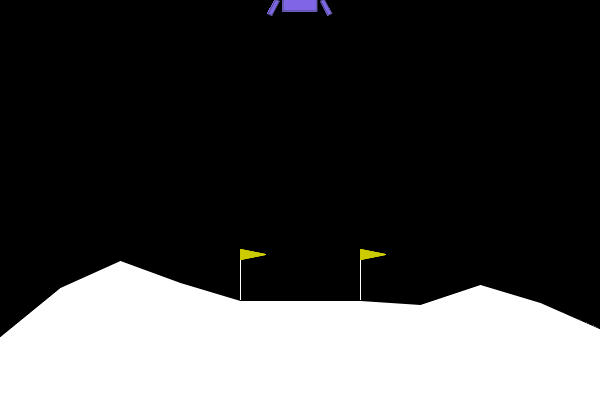

In [8]:
env.reset()
# Initializes the environment.
# This puts the lunar lander at the starting position (falling from above the landing pad).
# It also returns the initial observation (state):
# a NumPy array describing the lander’s position, velocity, angle, etc.
# You must call reset() before starting interactions.

PIL.Image.fromarray(env.render(mode='rgb_array'))
# env.render(mode='rgb_array') renders the current frame as an RGB image (NumPy array) instead of opening a window.
# Each pixel is represented by [R, G, B] values.
# PIL.Image.fromarray(...) converts that NumPy array into a PIL image object (so you can display or save it).
# If you’re in Jupyter Notebook, just leaving this line at the end will display the current frame of the environment as a still image.

In order to build our neural network later on we need to know the size of the state vector and the number of valid actions. We can get this information from our environment by using the `.observation_space.shape` and `action_space.n` methods, respectively.

In [9]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


<a name="5"></a>
## 5 - Interacting with the Gym Environment

The Gym library implements the standard “agent-environment loop” formalism:

<br>
<center>
<video src = "./videos/rl_formalism.m4v" width="840" height="480" controls autoplay loop poster="./images/rl_formalism.png"> </video>
<figcaption style = "text-align:center; font-style:italic">Fig 2. Agent-environment Loop Formalism.</figcaption>
</center>
<br>

In the standard “agent-environment loop” formalism, an agent interacts with the environment in discrete time steps $t=0,1,2,...$. At each time step $t$, the agent uses a policy $\pi$ to select an action $A_t$ based on its observation of the environment's state $S_t$. The agent receives a numerical reward $R_t$ and on the next time step, moves to a new state $S_{t+1}$.

<a name="5.1"></a>
### 5.1 Exploring the Environment's Dynamics

In Open AI's Gym environments, we use the `.step()` method to run a single time step of the environment's dynamics. In the version of `gym` that we are using the `.step()` method accepts an action and returns four values:

* `observation` (**object**): an environment-specific object representing your observation of the environment. In the Lunar Lander environment this corresponds to a numpy array containing the positions and velocities of the lander as described in section [3.2 Observation Space](#3.2). the new state $S_{t+1}$ of the environment.


* `reward` (**float**): amount of reward returned as a result of taking the given action. In the Lunar Lander environment this corresponds to a float of type `numpy.float64` as described in section [3.3 Rewards](#3.3).


* `done` (**boolean**): When done is `True`, it indicates the episode has terminated and it’s time to reset the environment. 


* `info` (**dictionary**): diagnostic information useful for debugging. We won't be using this variable in this notebook but it is shown here for completeness.

To begin an episode, we need to reset the environment to an initial state. We do this by using the `.reset()` method. 

In [10]:
# Reset the environment and get the initial state.
current_state = env.reset()
current_state

array([ 0.00191936,  1.4223009 ,  0.19439952,  0.50581443, -0.00221733,
       -0.04403442,  0.        ,  0.        ], dtype=float32)

Once the environment is reset, the agent can start taking actions in the environment by using the `.step()` method. Note that the agent can only take one action per time step. 

In the cell below you can select different actions and see how the returned values change depending on the action taken. Remember that in this environment the agent has four discrete actions available and we specify them in code by using their corresponding numerical value:

```python
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3
```

In [11]:
# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, _ = env.step(action)

# Display table with values.
utils.display_table(current_state, action, next_state, reward, done)

# Replace the `current_state` with the state after the action is taken
current_state = next_state


# In reinforcement learning, observation ≈ state information the agent receives from the environment.
# After the agent takes an action at time step t, the environment updates and returns:
# observation: the new state S_{t+1} of the environment.
# reward: the scalar feedback R_t.
# done: whether the episode ended.
# info: extra debug info.

In practice, when we train the agent we use a loop to allow the agent to take many consecutive actions during an episode.

<a name="6"></a>
## 6 - Deep Q-Learning

In cases where both the state and action space are discrete we can estimate the action-value function iteratively by using the Bellman equation:

$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$

This iterative method converges to the optimal action-value function $Q^*(s,a)$ as $i\to\infty$. This means that the agent just needs to gradually explore the state-action space and keep updating the estimate of $Q(s,a)$ until it converges to the optimal action-value function $Q^*(s,a)$. However, in cases where the state space is continuous it becomes practically impossible to explore the entire state-action space. Consequently, this also makes it practically impossible to gradually estimate $Q(s,a)$ until it converges to $Q^*(s,a)$.

In the Deep $Q$-Learning, we solve this problem by using a neural network to estimate the action-value function $Q(s,a)\approx Q^*(s,a)$. We call this neural network a $Q$-Network and it can be trained by adjusting its weights at each iteration to minimize the mean-squared error in the Bellman equation.

Unfortunately, using neural networks in reinforcement learning to estimate action-value functions has proven to be highly unstable. Luckily, there's a couple of techniques that can be employed to avoid instabilities. These techniques consist of using a ***Target Network*** and ***Experience Replay***. We will explore these two techniques in the following sections.

<a name="6.1"></a>
### 6.1 Target Network

We can train the $Q$-Network by adjusting it's weights at each iteration to minimize the mean-squared error in the Bellman equation, where the target values are given by:

$$
y = R + \gamma \max_{a'}Q(s',a';w)
$$

where $w$ are the weights of the $Q$-Network. This means that we are adjusting the weights $w$ at each iteration to minimize the following error:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}Q(s',a'; w)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

Notice that this forms a problem because the $y$ target is changing on every iteration. Having a constantly moving target can lead to oscillations and instabilities. To avoid this, we can create
a separate neural network for generating the $y$ targets. We call this separate neural network the **target $\hat Q$-Network** and it will have the same architecture as the original $Q$-Network. By using the target $\hat Q$-Network, the above error becomes:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}\hat{Q}(s',a'; w^-)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

where $w^-$ and $w$ are the weights of the target $\hat Q$-Network and $Q$-Network, respectively.

In practice, we will use the following algorithm: every $C$ time steps we will use the $\hat Q$-Network to generate the $y$ targets and update the weights of the target $\hat Q$-Network using the weights of the $Q$-Network. We will update the weights $w^-$ of the the target $\hat Q$-Network using a **soft update**. This means that we will update the weights $w^-$ using the following rule:
 
$$
w^-\leftarrow \tau w + (1 - \tau) w^-
$$

where $\tau\ll 1$. By using the soft update, we are ensuring that the target values, $y$, change slowly, which greatly improves the stability of our learning algorithm.

<a name="ex01"></a>
### Exercise 1

In this exercise you will create the $Q$ and target $\hat Q$ networks and set the optimizer. Remember that the Deep $Q$-Network (DQN) is a neural network that approximates the action-value function $Q(s,a)\approx Q^*(s,a)$. It does this by learning how to map states to $Q$ values.

To solve the Lunar Lander environment, we are going to employ a DQN with the following architecture:

* An `Input` layer that takes `state_size` as input.

* A `Dense` layer with `64` units and a `relu` activation function.

* A `Dense` layer with `64` units and a `relu` activation function.

* A `Dense` layer with `num_actions` units and a `linear` activation function. This will be the output layer of our network.


In the cell below you should create the $Q$-Network and the target $\hat Q$-Network using the model architecture described above. Remember that both the $Q$-Network and the target $\hat Q$-Network have the same architecture.

Lastly, you should set `Adam` as the optimizer with a learning rate equal to `ALPHA`. Recall that `ALPHA` was defined in the [Hyperparameters](#2) section. We should note that for this exercise you should use the already imported packages:
```python
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
```

In [12]:
state_size

(8,)

In [13]:
# UNQ_C1
# GRADED CELL

# Create the Q-Network
q_network = Sequential([
    ### START CODE HERE ### 
    Input(shape=state_size),
    Dense(units = 64, activation="relu"),
    Dense(units = 64, activation="relu"),
    Dense(units = num_actions, activation="linear")
    ### END CODE HERE ### 
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    ### START CODE HERE ### 
    Input(shape=state_size),
    Dense(units = 64, activation="relu"),
    Dense(units = 64, activation="relu"),
    Dense(units = num_actions, activation="linear")    
    
    
    
    ### END CODE HERE ###
    ])

### START CODE HERE ### 
optimizer = Adam(learning_rate=ALPHA)
### END CODE HERE ###

In [14]:
# UNIT TEST
from public_tests import *

# test_network(q_network)
# test_network(target_q_network)
test_optimizer(optimizer, ALPHA) 

All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size),                       
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'), 
    ])

optimizer = Adam(learning_rate=ALPHA)                                  
``` 

<a name="6.2"></a>
### 6.2 Experience Replay

When an agent interacts with the environment, the states, actions, and rewards the agent experiences are sequential by nature. If the agent tries to learn from these consecutive experiences it can run into problems due to the strong correlations between them. To avoid this, we employ a technique known as **Experience Replay** to generate uncorrelated experiences for training our agent. Experience replay consists of storing the agent's experiences (i.e the states, actions, and rewards the agent receives) in a memory buffer and then sampling a random mini-batch of experiences from the buffer to do the learning. The experience tuples $(S_t, A_t, R_t, S_{t+1})$ will be added to the memory buffer at each time step as the agent interacts with the environment.

For convenience, we will store the experiences as named tuples.

<details>
<summary><span style="color:red">Click to expand 👇</span></summary>

**🔹 The Problem**

When an agent (our RL algorithm) interacts with the environment:

- At time step $t$, it is in state $S_t$  
- It takes action $A_t$  
- It receives reward $R_t$  
- It moves to the next state $S_{t+1}$  

So the experience looks like:

$$
(S_t, A_t, R_t, S_{t+1})
$$  

Because the environment evolves sequentially, **consecutive experiences are strongly correlated**.

👉 Example: If the lander is descending quickly, then in the next step it is still descending quickly.

⚠️ If the agent trains directly on this sequential data, it may **overfit to recent sequences** and fail to generalize properly.

**🔹 The Solution → Experience Replay**  

Instead of training on consecutive experiences, we use a trick called **Experience Replay**:

- **Memory Buffer**: Keep a large buffer (replay memory) where we store all experiences:  
  $$
  (S_t, A_t, R_t, S_{t+1})
  $$  

- **Random Sampling**: When training the Q-network, instead of using only the most recent data, we **randomly sample a mini-batch** from the buffer.  

- **Uncorrelated Data**: Random sampling makes the batch **less correlated** than raw sequences, which stabilizes training.

**🔹 Benefits of Experience Replay**

- **Breaks correlations** → Makes data closer to i.i.d. (independent and identically distributed), fitting the assumptions of most neural optimizers.  
- **Improves efficiency** → Past experiences can be **reused many times**, instead of just once.  
- **Stabilizes learning** → Prevents the network from just memorizing the latest moves.  


**🔹 Named Tuples for Clarity**

In Python, to structure experiences cleanly, we often use `namedtuple`:

```python
from collections import namedtuple

Experience = namedtuple("Experience",
["state", "action", "reward", "next_state"])

Example usage
exp = Experience(state=S_t, action=A_t, reward=R_t, next_state=S_t1)
```

This makes the replay buffer **cleaner and easier to use**.


**✅ In short:**

**Experience Replay** = store past experiences in memory → randomly sample from them → train the agent.  

✔️ Benefits:  
- More stable learning  
- Better efficiency  
- Closer to supervised learning  

</details>

In [15]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

<details>
<summary><span style="color:red">Click to expand 👇</span></summary>  

This line is creating a **custom data structure** called `Experience` using Python’s `namedtuple` from the `collections` module.  

**🔹 Code**
```python
from collections import namedtuple

experience = namedtuple(
"Experience",
field_names=["state", "action", "reward", "next_state", "done"]
)
```

**🔎 Explanation**

**namedtuple**
- A lightweight way to create classes that **behave like tuples** but have **named fields**.  
- This means you can access elements by **name** instead of **index**, making it much more readable.

**"Experience"**
- This is the **name** of the new tuple type.  
- Think of it like defining a **small custom class**.

**field_names**
The fields inside each `Experience` tuple:  
- **state** → The environment’s state before the action  
- **action** → The action the agent took  
- **reward** → The immediate reward received  
- **next_state** → The environment’s state after the action  
- **done** → A Boolean (`True/False`) indicating if the episode has ended  

**Example Usage**  
```python
Create an experience
exp = experience(
state=[0.1, 0.2, 0.3],
action=1,
reward=1.0,
next_state=[0.2, 0.3, 0.4],
done=False
)

Access fields by name (not by index)
print(exp.state) # [0.1, 0.2, 0.3]
print(exp.action) # 1
print(exp.reward) # 1.0
print(exp.next_state) # [0.2, 0.3, 0.4]
print(exp.done) # False
```
**Summary**  

`Experience` is a **convenient container** for storing each experience tuple:  

$$
(S_t, A_t, R_t, S_{t+1}, \text{done})
$$  

This is exactly what gets stored in the **Replay Buffer** during reinforcement learning.
</details>

By using experience replay we avoid problematic correlations, oscillations and instabilities. In addition, experience replay also allows the agent to potentially use the same experience in multiple weight updates, which increases data efficiency.

<a name="7"></a>
## 7 - Deep Q-Learning Algorithm with Experience Replay

Now that we know all the techniques that we are going to use, we can put them together to arrive at the Deep Q-Learning Algorithm With Experience Replay.
<br>
<br>
<figure>
  <img src = "images/deep_q_algorithm.png" width = 90% style = "border: thin silver solid; padding: 0px">
      <figcaption style = "text-align: center; font-style: italic">Fig 3. Deep Q-Learning with Experience Replay.</figcaption>
</figure>

<a name="ex02"></a>
### Exercise 2

In this exercise you will implement line ***12*** of the algorithm outlined in *Fig 3* above and you will also compute the loss between the $y$ targets and the $Q(s,a)$ values. In the cell below, complete the `compute_loss` function by setting the $y$ targets equal to:

$$
\begin{equation}
    y_j =
    \begin{cases}
      R_j & \text{if episode terminates at step  } j+1\\
      R_j + \gamma \max_{a'}\hat{Q}(s_{j+1},a') & \text{otherwise}\\
    \end{cases}       
\end{equation}
$$

Here are a couple of things to note:

* The `compute_loss` function takes in a mini-batch of experience tuples. This mini-batch of experience tuples is unpacked to extract the `states`, `actions`, `rewards`, `next_states`, and `done_vals`. You should keep in mind that these variables are *TensorFlow Tensors* whose size will depend on the mini-batch size. For example, if the mini-batch size is `64` then both `rewards` and `done_vals` will be TensorFlow Tensors with `64` elements.


* Using `if/else` statements to set the $y$ targets will not work when the variables are tensors with many elements. However, notice that you can use the `done_vals` to implement the above in a single line of code. To do this, recall that the `done` variable is a Boolean variable that takes the value `True` when an episode terminates at step $j+1$ and it is `False` otherwise. Taking into account that a Boolean value of `True` has the numerical value of `1` and a Boolean value of `False` has the numerical value of `0`, you can use the factor `(1 - done_vals)` to implement the above in a single line of code. Here's a hint: notice that `(1 - done_vals)` has a value of `0` when `done_vals` is `True` and a value of `1` when `done_vals` is `False`. 

Lastly, compute the loss by calculating the Mean-Squared Error (`MSE`) between the `y_targets` and the `q_values`. To calculate the mean-squared error you should use the already imported package `MSE`:
```python
from tensorflow.keras.losses import MSE
```

In [16]:
# UNQ_C2
# GRADED FUNCTION: calculate_loss

def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1) #In TensorFlow, tf.reduce_max computes the maximum value of elements across a given axis of a tensor.
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ### 
    y_targets = rewards + (1 - done_vals)*gamma*max_qsa
    ### END CODE HERE ###
    
    # Get the q_values and reshape to match y_targets
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1)) #tf.gather_nd is a TensorFlow function that lets you pick out specific elements from a tensor using multi-dimensional indices.
        
    # Compute the loss
    ### START CODE HERE ### 
    loss = MSE(q_values, y_targets)
    ### END CODE HERE ### 
    
    return loss

In [17]:
# UNIT TEST    
test_compute_loss(compute_loss)

All tests passed!


<details>
<summary><span style="color:skyblue">Understanding `compute_loss(...)` in DQN</span></summary>  


This function implements the **core DQN update step**.  
It takes a minibatch of experience tuples and computes the loss that drives training.  

**Purpose (Big Picture)**

For a minibatch of experiences $(s, a, r, s', \text{done})$, we build **Bellman targets**:

$$
y = 
\begin{cases} 
r & \text{if done} \\
r + \gamma \max_{a'} Q_{\text{target}}(s', a') & \text{otherwise}
\end{cases}
$$

We then compare $y$ to the **online Q-network’s prediction** $Q_\theta(s, a)$.  
The **loss** is the Mean Squared Error (MSE):  

$$
L = \frac{1}{B}\sum_{i=1}^B \big(Q_\theta(s_i, a_i) - y_i\big)^2
$$

Minimizing this loss makes the network approximate the **Bellman equation**.

**🔹 Function Arguments**

- **`experiences`**: a minibatch of size `B`, unpacked into:
  - `states`: shape `(B, state_dim)`
  - `actions`: shape `(B,)`, integers in `[0, num_actions)`
  - `rewards`: shape `(B,)`, floats
  - `next_states`: shape `(B, state_dim)`
  - `done_vals`: shape `(B,)`, booleans or `{0,1}` floats


- **`gamma`**: discount factor $\gamma \in (0,1]$  
- **`q_network`**: the online Q-network $Q_\theta$ (being trained)  
- **`target_q_network`**: target Q-network $Q_{\bar\theta}$ (used for stable targets)  

**Step by Step**  

**1. Unpack minibatch**  
```python
states, actions, rewards, next_states, done_vals = experiences
```
**2. Compute target values via Bellman equation**  
```python
max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1) #compute \max_{a'} Q_{\bar\theta}(s', a') per next state using the target network.
y_targets = rewards + (1 - done_vals) * gamma * max_qsa
```
- `target_q_network(next_states)` → shape `(B, num_actions)`  
- `reduce_max(..., axis=-1)` → shape `(B,)`  
- Implements:

$$
y_i = 
\begin{cases}
r_i & \text{if done} \\
r_i + \gamma \max_{a'} Q_{\bar\theta}(s'_i, a') & \text{otherwise}
\end{cases}
$$

⚠️ Make sure `done_vals` is float (`tf.float32`). If boolean, cast it:  
done_vals = tf.cast(done_vals, tf.float32)


**3. Compute predicted Q-values**  
```python
q_values_all = q_network(states) # (B, num_actions)
q_values = tf.gather_nd(
q_values_all,
tf.stack([tf.range(q_values_all.shape), tf.cast(actions, tf.int32)], axis=1)
)
```
- Selects $Q_\theta(s, a)$ for each experience.  
- After gather → `q_values` has shape `(B,)`  


**4. Compute loss**
```python
loss = tf.reduce_mean(tf.square(q_values - y_targets))
```

- This is the **MSE loss**.  
- Scalar output, averaged across batch $(B,)$.  

**💡 Why Use a Target Network?**

- **Problem**: If we use $Q_\theta$ (the online net) for both sides of the update, the targets move every step → unstable training.  
- **Solution**: Use a slowly updated **target network** $Q_{\bar\theta}$ to stabilize training.  

**⚠️ Common Pitfalls / Gotchas**

- **Dtypes**: cast `done_vals` to float (`0.0/1.0`)  
- **No gradient through targets**: targets come from `target_q_network`, so they are treated as constants (no `stop_gradient` needed explicitly unless online net is used).  
- **Shape alignment**: ensure `q_values` and `y_targets` are both shape `(B,)`.  
- **Action type**: `actions` must be `int32` for indexing.  

**Usage in Training**  

Typical training step with TF2:
```python
with tf.GradientTape() as tape:
loss = compute_loss(batch, gamma, q_network, target_q_network)

grads = tape.gradient(loss, q_network.trainable_variables)
optimizer.apply_gradients(zip(grads, q_network.trainable_variables))
```

This pushes $Q_\theta(s, a)$ toward the **target** generated from the **target network** — the essence of the **DQN update**.

</details>

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    
    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    
    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
    
    # Calculate the loss
    loss = MSE(y_targets, q_values)
    
    return loss

``` 
    

<details>
<summary><span style="color:skyblue">Further Explanation</span></summary> 

**1. Before Indexing**
```python
q_values = q_network(states)
```
- **Input:** `states` shape `(B, state_dim)`
- **Output:** `q_values` shape `(B, num_actions)`
- For each state in the minibatch, the network predicts a **vector of Q-values**, one per action.

**Example (B=3, num_actions=4):**
```python
q_values =
[[ 2.1, -1.3, 0.5, 4.2], # Q(s1, all actions)
[ 0.7, 1.2, -0.4, 3.0], # Q(s2, all actions)
[-0.9, 2.5, 1.1, 0.0]] # Q(s3, all actions)
```

**2. The Goal**

We only want the **Q-value of the action actually taken** in each experience:
- For a batch: select $Q_\theta(s_i, a_i)$ for each $i$

If `actions = [3, 0, 1]`, we want:
[4.2, 0.7, 2.5] # one per row, indexed by action


**3. How the Indexing Works**
```python
indices = tf.stack([tf.range(q_values.shape), tf.cast(actions, tf.int32)], axis=1)
```

- `tf.range(q_values.shape)` → `[0, 1, 2]` (batch indices)
- `actions` (cast to `int32`) → `[3, 0, 1]`
- Stacking along axis 1:
```python
[[0, 3],
 [1, 0],
 [2, 1]]
# A list of (row_index, col_index) pairs.
```

**4. Gathering**
```python
q_values = tf.gather_nd(q_values, indices)
```
This extracts:

Row 0, Col 3 → 4.2

Row 1, Col 0 → 0.7

Row 2, Col 1 → 2.5

Result:

```python
q_values = [4.2, 0.7, 2.5]
```

**5. Shape After Gather** 
Before: (B, num_actions)

After: (B,)

Now, q_values matches y_targets — so you can compute the loss directly.

✅ In plain words
That line is just a neat way of selecting, for each experience in the batch, the Q-value corresponding to the specific action actually taken.
</details>

<details>
<summary><span style="color:skyblue">

**"Why is the cost function in theory often written as $\tfrac{1}{2} \cdot \text{MSE}$, while in practice (e.g., TensorFlow’s `MSE` loss) we don’t include the $\tfrac{1}{2}$? And why do we sometimes multiply `sklearn.metrics.mean_squared_error` by $\tfrac{1}{2}$ when computing the cost function?"**

</span></summary> 

Aha 🔥 very good catch — this is exactly where notation vs. implementation can confuse. Let’s untangle it:

1. In Machine Learning theory (e.g., Andrew Ng’s course)  
The cost function for linear regression is defined as  
$$
J(\theta) = \frac{1}{2m} \sum_{i=1}^m \big( h_\theta(x^{(i)}) - y^{(i)} \big)^2
$$  
The $\frac{1}{2}$ is put there only for mathematical convenience.  
Why? Because when you take the derivative wrt $\theta$, that 2 cancels out, leaving cleaner gradients.  
So: cost function = $\frac{1}{2} \cdot \text{MSE}$.

2. In sklearn.metrics.mean_squared_error  
mean_squared_error just computes  
$$
\text{MSE} = \frac{1}{m} \sum_{i=1}^m (y_i - \hat{y}_i)^2
$$  
👉 No $\frac{1}{2}$ included.  
So when you see people write:  
`cost_j = 1/2 * mean_squared_error(y, y_pred)`  
they are manually adding the $\frac{1}{2}$ to match the cost function definition from theory (not because sklearn requires it).

3. In Deep Learning frameworks (TensorFlow / PyTorch)  
Loss functions like MSE are used directly in optimization.  
Since optimizers (Adam, SGD, etc.) don’t care about constants (scaling is absorbed into learning rate), frameworks don’t bother with the $\frac{1}{2}$.  
That’s why `tf.keras.losses.MSE` = just raw MSE.

✅ Bottom line:  
Theory (Andrew Ng style): cost = $\frac{1}{2} \cdot \text{MSE}$ (for clean math).  
sklearn: mean_squared_error = raw MSE, you can multiply by $\frac{1}{2}$ if you want to replicate the cost function from theory.  
TensorFlow / PyTorch: use raw MSE, no $\frac{1}{2}$ — optimizers take care of scaling.

Would you like me to show you a side-by-side example with sklearn + TensorFlow where I compute both, so you can see numerically how the factor of $\frac{1}{2}$ shows up?


</details>

<a name="8"></a>
## 8 - Update the Network Weights

We will use the `agent_learn` function below to implement lines ***12 -14*** of the algorithm outlined in [Fig 3](#7). The `agent_learn` function will update the weights of the $Q$ and target $\hat Q$ networks using a custom training loop. Because we are using a custom training loop we need to retrieve the gradients via a `tf.GradientTape` instance, and then call `optimizer.apply_gradients()` to update the weights of our $Q$-Network. Note that we are also using the `@tf.function` decorator to increase performance. Without this decorator our training will take twice as long. If you would like to know more about how to increase performance with `@tf.function` take a look at the [TensorFlow documentation](https://www.tensorflow.org/guide/function).

The last line of this function updates the weights of the target $\hat Q$-Network using a [soft update](#6.1). If you want to know how this is implemented in code we encourage you to take a look at the `utils.update_target_network` function in the `utils` module.

The flow is roughly like this:

1) Agent interacts with the environment
   - At each time step, the agent takes an action, collects (state, action, reward, next_state, done), and stores it in the replay buffer.

2) Experience Replay Sampling
    - Once the replay buffer has at least a minimum number of experiences (say 1000 transitions), we start sampling mini-batches (e.g. 64 experiences) randomly.

3) Update Step
    - Every time we sample such a mini-batch, we call agent_learn(...) → this computes the loss and updates parameters using backpropagation.

In [18]:
@tf.function
#Runs one optimization step for the online Q-network using a minibatch of experiences and the discount factor γ.
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    #Forward pass + loss (inside a tape)
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)
        '''
        tf.GradientTape records all ops needed to compute gradients.
        compute_loss(...) implements the DQN Bellman error:
          - Builds targets: y = r + (1-d) \,\gamma \max_{a'} Q_{\text{target}}(s', a') #That (1−d) term comes from how we handle the end of an episode in reinforcement learning.
          - Predicts current Q(s,a) from q_network
          - Returns MSE between Q_theta(s,a) and y.
        '''

    # Get the gradients of the loss with respect to the weights.
    # Backpropagation:
    gradients = tape.gradient(loss, q_network.trainable_variables)
    '''
    Computes ∇_theta loss w.r.t. the online network’s parameters only.
    If any gradient is None, it means that variable didn’t influence the loss (check variable connection or dtypes). It means: That particular weight/bias (var) wasn’t used (or properly connected) in computing the loss, so TensorFlow can’t backpropagate a gradient for it.
    '''
    # Update the weights of the q_network.
    # Optimizer step:
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))
    '''
    Applies the gradients (e.g., Adam/SGD) to update the online Q-network weights.
    This is the core learning step.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))
    Step by step:
    gradients: A list of tensors, each tensor is the gradient of the loss with respect to a trainable variable in q_network.
      Example: [grad_w1, grad_b1, grad_w2, grad_b2, ...]

    q_network.trainable_variables: A list of the actual parameters (weights and biases) in the model that need to be updated.
      Example: [W1, b1, W2, b2, ...]

    zip(gradients, q_network.trainable_variables): Pairs each gradient with the variable it belongs to.
      Example:

      scss
      Copy
      Edit
      (grad_w1, W1)
      (grad_b1, b1)
      (grad_w2, W2)
      (grad_b2, b2)
      ...
    optimizer.apply_gradients(...): The optimizer then updates each variable using its corresponding gradient.
    For Adam, the update is something like: theta \leftarrow theta - alpha \cdot text{corrected_gradient}

    
    🔑 Why zip is needed?
        Because apply_gradients expects a list of (gradient, variable) tuples.
        Without zip, the optimizer wouldn’t know which gradient belongs to which variabl
    '''

    # update the weights of target q_network
    utils.update_target_network(q_network, target_q_network)

<details>
    <summary><span style="color:skyblue">utils.update_target_network(q_network, target_q_network)</span></summary> 


**1. Why do we need a target network?**  

In Deep Q-Learning, we have:  
- **q_network:** the main network (learns and updates at every step).  
- **target_q_network:** a stable copy of the main network, used to compute the target values  

$$
y = r + \gamma \max Q_{\text{target}}(s', a')
$$

If we only used the main network for both predicting and updating, it could chase its own moving target → unstable learning.  
The target network adds stability.

**2. The problem of updates**  

If we copied the weights of `q_network` to `target_q_network` every time step, the target would change too fast → instability.  
Instead, we use a *soft update*:  

$$
w_{\text{target}} \leftarrow \tau w + (1 - \tau) w_{\text{target}}
$$

- $w$: weights of the main `q_network`  
- $w_{\text{target}}$: weights of the `target_q_network`  
- $\tau$: a small constant (e.g., 0.001)  

This makes the target network slowly “track” the main network.

**3. What the code does**  
```python
for target_weights, q_net_weights in zip(
target_q_network.weights, q_network.weights
):
target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)
```

- `zip(...)` pairs each weight in the target network with the corresponding weight in the main network.  
- For each pair:  
  - Compute new target weight = a blend of old target weight and current main network weight.  
  - `assign(...)` overwrites the target weight with this new value.

**4. Analogy**

Imagine the `q_network` is running forward quickly, discovering things.  
The `target_q_network` is like a cautious friend walking behind, not rushing, just keeping pace slowly.  
This way, the target is stable but still eventually catches up.

**✅ Summary:**  

This function softly updates the target network so it doesn’t change too fast. That stabilizes training and prevents oscillations or divergence.

Would you like me to also show you the difference between *soft update* and *hard update* with a little numeric example (like with simple numbers instead of weights)?

</details>


<details>
    <summary><span style="color:skyblue">What does 'episode' mean in the context of RL?</span></summary> 


**In reinforcement learning (RL), an **episode** is one full run of the agent interacting with the environment from start to finish.**

**🔹 In your LunarLander-v2 case:**

- An episode starts when you call:  
```python
state = env.reset()
```
→ the lander is placed at a random starting position above the landing pad.

- The agent then takes actions step by step:  
```python
next_state, reward, done, _ = env.step(action)
```
and collects rewards.

- The episode ends when:  
- The lander successfully lands 🚀 (`done = True`),  
- The lander crashes 💥 (`done = True`), or  
- The maximum number of timesteps (e.g., 1000) is reached ⏳.

**🔹 Why episodes are important:**

- RL is about learning from **trial and error**.  
- Each episode is like one attempt at solving the task.  
- The **total reward** in an episode (sum of rewards across all steps) measures how well the agent did.  
- During training, we run many episodes (e.g., 2000 in your code) so the agent gradually improves.


👉 Think of an episode like playing one full game of Lunar Lander.  
When the game ends (land, crash, or timeout), the episode ends.  
Then a new episode starts with a fresh reset.

</detail>



<details>
    <summary><span style="color:skyblue">'episode' vs. Timestep</span></summary> 


**🔹 Timestep**

A **timestep** is one step of interaction between the agent and the environment.  
At each timestep $t$:  
- The agent observes the current state $S_t$.  
- Chooses an action $A_t$.  
- Receives a reward $R_t$.  
- The environment transitions to the next state $S_{t+1}$.  

📌 Example in Lunar Lander:  
At timestep 42, the lander might fire the left engine, get a reward of -0.1, and shift position slightly.

**🔹 Episode**

An **episode** is a full sequence of timesteps from the start state until a terminal condition (`done=True`) is reached.  
It is made up of many timesteps.  
Episodes vary in length:  
- Some may end quickly if the lander crashes 💥.  
- Some may last longer if the agent lands slowly and carefully 🚀.  

📌 Example:  
- Episode 1 = 356 timesteps  
- Episode 2 = 987 timesteps  
- Episode 3 = 120 timesteps (crash)

**🔹 Analogy 🎮**

- **Timestep** = one move you make in a video game.  
- **Episode** = one full playthrough of the game (from "start game" to "game over").

👉 In your code:
```python
for i in range(num_episodes): # Episodes
for t in range(max_num_timesteps): # Timesteps
...
```

- The outer loop is for episodes (e.g., 2000 games).  
- The inner loop is for timesteps (e.g., max 1000 moves per game).


<a name="9"></a>
## 9 - Train the Agent

We are now ready to train our agent to solve the Lunar Lander environment. In the cell below we will implement the algorithm in [Fig 3](#7) line by line (please note that we have included the same algorithm below for easy reference. This will prevent you from scrolling up and down the notebook):

* **Line 1**: We initialize the `memory_buffer` with a capacity of $N =$ `MEMORY_SIZE`. Notice that we are using a `deque` as the data structure for our `memory_buffer`.


* **Line 2**: We skip this line since we already initialized the `q_network` in [Exercise 1](#ex01).


* **Line 3**: We initialize the `target_q_network` by setting its weights to be equal to those of the `q_network`.


* **Line 4**: We start the outer loop. Notice that we have set $M =$ `num_episodes = 2000`. This number is reasonable because the agent should be able to solve the Lunar Lander environment in less than `2000` episodes using this notebook's default parameters.


* **Line 5**: We use the `.reset()` method to reset the environment to the initial state and get the initial state.


* **Line 6**: We start the inner loop. Notice that we have set $T =$ `max_num_timesteps = 1000`. This means that the episode will automatically terminate if the episode hasn't terminated after `1000` time steps.


* **Line 7**: The agent observes the current `state` and chooses an `action` using an $\epsilon$-greedy policy. Our agent starts out using a value of $\epsilon =$ `epsilon = 1` which yields an $\epsilon$-greedy policy that is equivalent to the equiprobable random policy. This means that at the beginning of our training, the agent is just going to take random actions regardless of the observed `state`. As training progresses we will decrease the value of $\epsilon$ slowly towards a minimum value using a given $\epsilon$-decay rate. We want this minimum value to be close to zero because a value of $\epsilon = 0$ will yield an $\epsilon$-greedy policy that is equivalent to the greedy policy. This means that towards the end of training, the agent will lean towards selecting the `action` that it believes (based on its past experiences) will maximize $Q(s,a)$. We will set the minimum $\epsilon$ value to be `0.01` and not exactly 0 because we always want to keep a little bit of exploration during training. If you want to know how this is implemented in code we encourage you to take a look at the `utils.get_action` function in the `utils` module.


* **Line 8**: We use the `.step()` method to take the given `action` in the environment and get the `reward` and the `next_state`. 


* **Line 9**: We store the `experience(state, action, reward, next_state, done)` tuple in our `memory_buffer`. Notice that we also store the `done` variable so that we can keep track of when an episode terminates. This allowed us to set the $y$ targets in [Exercise 2](#ex02).


* **Line 10**: We check if the conditions are met to perform a learning update. We do this by using our custom `utils.check_update_conditions` function. This function checks if $C =$ `NUM_STEPS_FOR_UPDATE = 4` time steps have occured and if our `memory_buffer` has enough experience tuples to fill a mini-batch. For example, if the mini-batch size is `64`, then our `memory_buffer` should have more than `64` experience tuples in order to pass the latter condition. If the conditions are met, then the `utils.check_update_conditions` function will return a value of `True`, otherwise it will return a value of `False`.


* **Lines 11 - 14**: If the `update` variable is `True` then we perform a learning update. The learning update consists of sampling a random mini-batch of experience tuples from our `memory_buffer`, setting the $y$ targets, performing gradient descent, and updating the weights of the networks. We will use the `agent_learn` function we defined in [Section 8](#8) to perform the latter 3.


* **Line 15**: At the end of each iteration of the inner loop we set `next_state` as our new `state` so that the loop can start again from this new state. In addition, we check if the episode has reached a terminal state (i.e we check if `done = True`). If a terminal state has been reached, then we break out of the inner loop.


* **Line 16**: At the end of each iteration of the outer loop we update the value of $\epsilon$, and check if the environment has been solved. We consider that the environment has been solved if the agent receives an average of `200` points in the last `100` episodes. If the environment has not been solved we continue the outer loop and start a new episode.

Finally, we wanted to note that we have included some extra variables to keep track of the total number of points the agent received in each episode. This will help us determine if the agent has solved the environment and it will also allow us to see how our agent performed during training. We also use the `time` module to measure how long the training takes. 

<br>
<br>
<figure>
  <img src = "images/deep_q_algorithm.png" width = 90% style = "border: thin silver solid; padding: 0px">
      <figcaption style = "text-align: center; font-style: italic">Fig 4. Deep Q-Learning with Experience Replay.</figcaption>
</figure>
<br>

**Note:** With this notebook's default parameters, the following cell takes between 10 to 15 minutes to run. 

In [19]:
start = time.time() #time.time() returns the current time in seconds since the Unix epoch (January 1, 1970). So start stores the timestamp when your training began.

num_episodes = 2000 #Run at most 2000 episodes.
max_num_timesteps = 1000 #Each episode has at most 1000 steps before stopping.

total_point_history = [] #tracks rewards per episode.

num_p_av = 100    # number of total points to use for averaging. used for a moving average of performance (last 100 episodes).
epsilon = 1.0     # initial ε value for ε-greedy policy (start fully random, ε=1.0).

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE) # Experience replay buffer with finite capacity MEMORY_SIZE.

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())
'''
Why Do We Need Synchronization?
In Deep Q-Learning:
    Q-Network (q_network): gets updated every training step using gradient descent.
    Target Q-Network (target_q_network): used to compute stable target values for training.
At the beginning of training, the target network should match the Q-Network (otherwise you’d be comparing against a random network, which doesn’t make sense).
That’s what:    target_q_network.set_weights(q_network.get_weights())
does → it copies all weights from q_network into target_q_network.

After That:
    During training, q_network updates every batch.
    target_q_network updates more slowly (via your update_target_network function with the soft update rule).

This keeps learning stable.
'''
for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset() #Reset environment. 'state' is the first observation. total_points = total reward in this episode.
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network # make shape (1,8)
        q_values = q_network(state_qn) #Pass the state into Q-network → get Q-values for all actions.
        action = utils.get_action(q_values, epsilon) #Use ε-greedy policy: with prob ε pick random action, otherwise pick argmax Q.
        
        # Take action A and receive reward R and the next state S'
        #Take action in env:
        next_state, reward, done, _ = env.step(action)
        '''
        Env returns:
            next_state: new observation
            reward: scalar reward
            done: whether episode ended
            _: extra info (unused)
        '''
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done)) #Save transition (S, A, R, S', done) into replay memory.
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        #Training step (only sometimes):
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        '''
        Only update every NUM_STEPS_FOR_UPDATE steps.
        If yes → sample random mini-batch from buffer → call agent_learn (gradient update + target update).
        '''
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
        '''
        Move to next state.
        Accumulate reward.
        If episode ended → exit loop.
        '''   
    # After Episode:
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:]) #Track total reward. Compute moving average of last 100 rewards. → “take the last up to 100 episode scores.” If fewer than 100 episodes are done, it just takes all of them
    
    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="") #\r means “carriage return” → move the cursor back to the start of the line. end="" means don’t print a newline at the end. So this line overwrites the same console line each iteration.
    '''
    BUT notice the end="".
    That tells Python not to move to a new line → so it keeps overwriting the same line in your terminal (like a progress bar).
    That’s why you don’t see 1, 2, 3, … in the final log. They happened, but each new line replaced the previous one.

    Then, every 100 episodes ((i+1) % num_p_av == 0), you run:
    print(f"\rEpisode {i+1} | Total point average ...")
    This time it doesn’t have end="", so it moves to a new line.

    That’s why the log keeps the message at 100, 200, 300, … episodes.
    '''
    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5') #Save trained model.
        break
        
tot_time = time.time() - start
'''
Again, time.time() is called → this gives the timestamp right now (when training finished).
Subtracting start gives the elapsed time (duration).
'''
print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -151.58
Episode 200 | Total point average of the last 100 episodes: -115.07
Episode 300 | Total point average of the last 100 episodes: -66.156
Episode 400 | Total point average of the last 100 episodes: 4.5761
Episode 500 | Total point average of the last 100 episodes: 131.79
Episode 600 | Total point average of the last 100 episodes: 186.52
Episode 700 | Total point average of the last 100 episodes: 186.55
Episode 740 | Total point average of the last 100 episodes: 198.93

Episode 741 | Total point average of the last 100 episodes: 201.39

Environment solved in 741 episodes!

Total Runtime: 809.97 s (13.50 min)


We can plot the total point history along with the moving average to see how our agent improved during training. If you want to know about the different plotting options available in the `utils.plot_history` function we encourage you to take a look at the `utils` module.

74


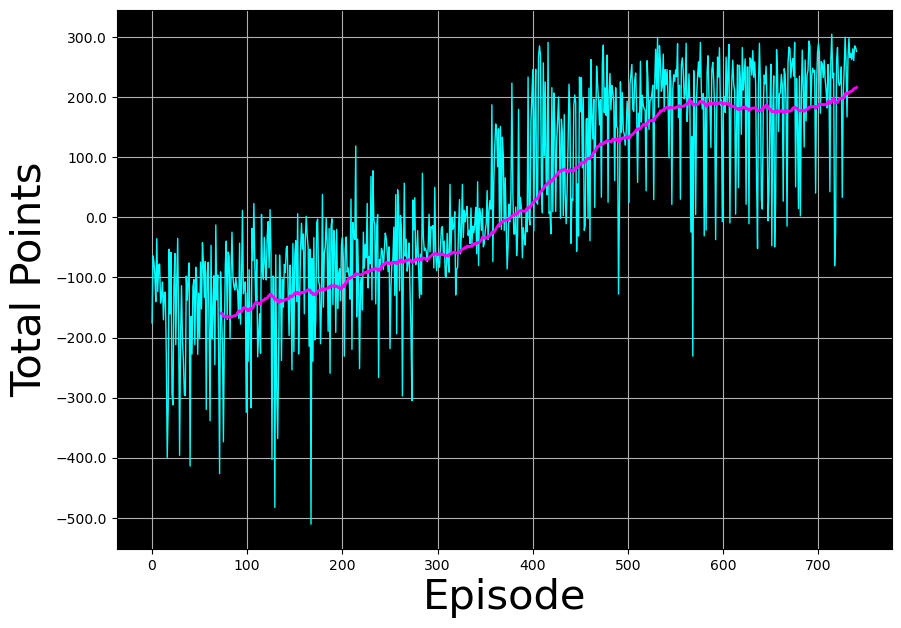

In [20]:
# Plot the total point history along with the moving average
utils.plot_history(total_point_history)

# In plotting (plot_history)
# The rolling mean is created by:
# rolling_mean = pd.DataFrame(points).rolling(window_size).mean()
# Default window_size = 10% of len(point_history)
# For ~720 episodes, that’s about 72 episodes.
# By default, pandas.DataFrame.rolling(window_size).mean() uses
# min_periods=None, which defaults to window_size.
# That means the rolling mean is NaN for the first window_size-1 points, and the first non‑NaN value appears at index window_size-1.

# That’s why your pink line begins near episode 0 instead of 100.

In [21]:
import random
random.randint(1, 496) #390

272

<a name="10"></a>
## 10 - See the Trained Agent In Action

Now that we have trained our agent, we can see it in action. We will use the `utils.create_video` function to create a video of our agent interacting with the environment using the trained $Q$-Network. The `utils.create_video` function uses the `imageio` library to create the video. This library produces some warnings that can be distracting, so, to suppress these warnings we run the code below.

In [22]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In the cell below we create a video of our agent interacting with the Lunar Lander environment using the trained `q_network`. The video is saved to the `videos` folder with the given `filename`. We use the `utils.embed_mp4` function to embed the video in the Jupyter Notebook so that we can see it here directly without having to download it.

We should note that since the lunar lander starts with a random initial force applied to its center of mass, every time you run the cell below you will see a different video. If the agent was trained properly, it should be able to land the lunar lander in the landing pad every time, regardless of the initial force applied to its center of mass.

In [23]:
filename = "./videos/lunar_lander.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

<a name="11"></a>
## 11 - Congratulations!

You have successfully used Deep Q-Learning with Experience Replay to train an agent to land a lunar lander safely on a landing pad on the surface of the moon. Congratulations!

<a name="12"></a>
## 12 - References

If you would like to learn more about Deep Q-Learning, we recommend you check out the following papers.


* Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015).


* Lillicrap, T. P., Hunt, J. J., Pritzel, A., et al. Continuous Control with Deep Reinforcement Learning. ICLR (2016).


* Mnih, V., Kavukcuoglu, K., Silver, D. et al. Playing Atari with Deep Reinforcement Learning. arXiv e-prints.  arXiv:1312.5602 (2013).

<details>
  <summary><font size="2" color="darkgreen"><b>Please click here if you want to experiment with any of the non-graded code.</b></font></summary>
    <p><i><b>Important Note: Please only do this when you've already passed the assignment to avoid problems with the autograder.</b></i>
    <ol>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “Edit Metadata”</li>
        <li> Hit the “Edit Metadata” button next to the code cell which you want to lock/unlock</li>
        <li> Set the attribute value for “editable” to:
            <ul>
                <li> “true” if you want to unlock it </li>
                <li> “false” if you want to lock it </li>
            </ul>
        </li>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “None” </li>
    </ol>
    <p> Here's a short demo of how to do the steps above: 
        <br>
        <img src="https://drive.google.com/uc?export=view&id=14Xy_Mb17CZVgzVAgq7NCjMVBvSae3xO1" align="center" alt="unlock_cells.gif">
</details>